In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*2)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.21:54605 Dashboard: http://10.148.0.21:8787/status,Cluster Workers: 28 Cores: 28 Memory: 479.92 GB


________________
### Readme: 
In this notebook, some basic information (e.g., bathymetry of the model domain, record-mean/max/min mixed layer depth, snapshots of u,v,w,b) are given in section 2. 

Section 3 displays some estimates based on the model output such as Rossby number, lateral buoyancy gradient, PV, Frontogenesis function. 

Raw outputs and 1-day low-pass filtered data are used in Section 3.

_________
# 1. Read dataset



In [5]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_B = xr.open_zarr(out_dir_zarr+'Buoy_total_rechunk.zarr')
ds_MLD = xr.open_zarr(out_dir_zarr+'mld_filter.zarr')

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/22)
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    ...          ...
    dyG         (lat, lon_g) float32 ...
    rA          (lat, lon) float32 ...
    rAz         (lat_g, lon_g) float32 ...
    rAw         (lat, lon_g) float32 ...
    rAs         (lat_g, lon) float32 ...
  * depth_left  (depth_left) float64 -0.035 1.035 2.18 ... 878.0 922.9 968.9
Data variables:
    U           (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1,

In [7]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary=None):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic, boundary=None):
  * center   depth --> left
  * left     depth_left --> center


In [9]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')

In [10]:
out_dir_zarr = '/home1/scratch/xyu/KE/data_rechunk_filter/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_1day_lowpass_filter.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_1day_lowpass_filter.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_1day_lowpass_filter.zarr')
ds_B_lowpass = xr.open_zarr(out_dir_zarr+'B_1day_lowpass_filter.zarr')

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds_filter = ds_filter.assign_coords(time=time_day) 
print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates: (12/21)
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
    dxC           (lat, lon_g) float32 1.568e+03 1.568e+03 ... 1.489e+03
    dyG           (lat, lon_g) float32 1.469e+03 1.469e+03 ... 1.403e+03
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    rAw           (lat, lon_g) float32 2.302e+06 2.302e+06 ... 2.09e+06 2.09e+06
    ...            ...
    XC            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    YC            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    rA            (lat, lon) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    XG            (lat_g, lon_g) float32 ...
    YG            (lat_g, lon_g) float32 ...
    rAz           (lat_g, lon_g) float32 ...
Data 

## 2 Rossby number

In [11]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta_f = (zeta/f)

zeta_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') - gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
zeta_filter_f = (zeta_filter/f)

print(zeta_f)

<xarray.DataArray (lat_g: 201, lon_g: 177, time: 9415, depth: 52)>
dask.array<truediv, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(1, 176, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    XG       (lat_g, lon_g) float32 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    YG       (lat_g, lon_g) float32 47.4 47.4 47.4 47.4 ... 49.98 49.98 49.98
    rAz      (lat_g, lon_g) float32 2.303e+06 2.303e+06 ... 2.09e+06 2.09e+06


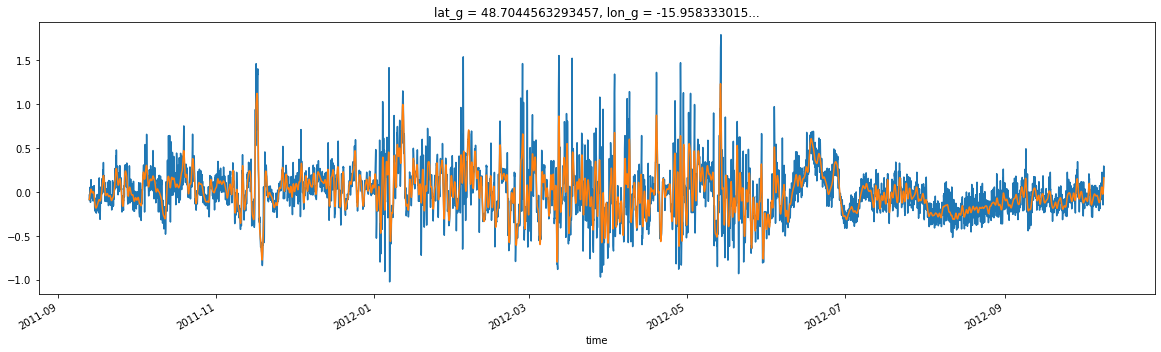

In [12]:
fig = plt.figure(figsize=(20,5))

zeta_f.isel(lat_g=100, lon_g=100,depth=1).plot()
zeta_filter_f.isel(lat_g=100, lon_g=100,depth=1).plot()

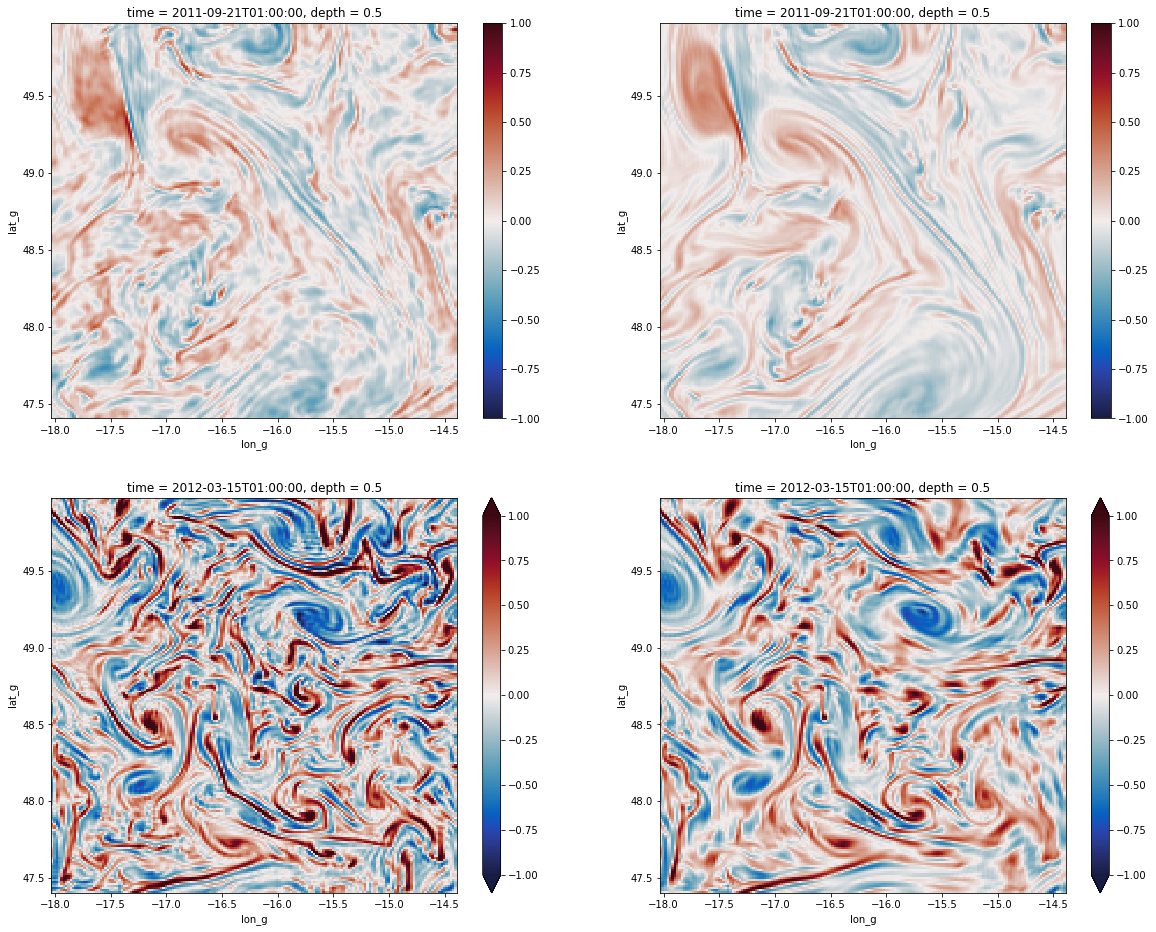

In [18]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
zeta_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(222)
zeta_filter_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)

plt.subplot(223)
zeta_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(224)
zeta_filter_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)

In [13]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [14]:
# 25 mins
VV = ['zeta_filter_f']

for depth in depth_all:
    
    for vv in VV:
        
        zeta_single = zeta_filter_f.isel(depth=depth)
        chunks = {'lat_g': 1, 'lon_g': 177, 'time':9415}            
        zeta_single = zeta_single.chunk(chunks)
        zeta_single = np.real(zeta_single).rename('zeta_single')     
        zeta_single = zeta_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        zeta_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [65]:
# 25 mins
VV = ['zeta_f']

for depth in depth_all:
    
    for vv in VV:
        
        zeta_single = zeta_f.isel(depth=depth)
        chunks = {'lat_g': 1, 'lon_g': 177, 'time':9415}            
        zeta_single = zeta_single.chunk(chunks)
        zeta_single = np.real(zeta_single).rename('zeta_single')     
        zeta_single = zeta_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        zeta_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed


# 3. Read zeta estimates

In [25]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'zeta_filter_f_d%02d.zarr'%(depth)) for depth in range(1)]
zeta = xr.concat(D, dim='depth')
print(zeta)
print('\n data size: %.1f GB' %(zeta.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (depth: 1, lat_g: 201, lon_g: 177, time: 9415)
Coordinates:
    XG           (lat_g, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    YG           (lat_g, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * depth        (depth) float64 0.5
  * lat_g        (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon_g        (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    rAz          (lat_g, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * time         (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    zeta_single  (depth, lat_g, lon_g, time) float32 dask.array<chunksize=(1, 1, 177, 9415), meta=np.ndarray>

 data size: 1.3 GB


In [26]:
out_dir_store = '/home1/scratch/xyu/KE/parameter/'
D = [xr.open_zarr(out_dir_store+'zeta_f_d%02d.zarr'%(depth)) for depth in range(1)]
zeta_raw = xr.concat(D, dim='depth')
print(zeta_raw)
print('\n data size: %.1f GB' %(zeta_raw.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (depth: 1, lat_g: 201, lon_g: 177, time: 9415)
Coordinates:
    XG           (lat_g, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    YG           (lat_g, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * depth        (depth) float64 0.5
  * lat_g        (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon_g        (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    rAz          (lat_g, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * time         (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    zeta_single  (depth, lat_g, lon_g, time) float32 dask.array<chunksize=(1, 1, 177, 9415), meta=np.ndarray>

 data size: 1.3 GB


In [27]:
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
zeta = zeta.assign_coords(time=time_day) 
zeta

<xarray.Dataset>
Dimensions:      (depth: 1, lat_g: 201, lon_g: 177, time: 9415)
Coordinates:
    XG           (lat_g, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
    YG           (lat_g, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * depth        (depth) float64 0.5
  * lat_g        (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon_g        (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    rAz          (lat_g, lon_g) float32 dask.array<chunksize=(1, 177), meta=np.ndarray>
  * time         (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    zeta_single  (depth, lat_g, lon_g, time) float32 dask.array<chunksize=(1, 1, 177, 9415), meta=np.ndarray>

In [28]:
zeta_raw = zeta_raw.assign_coords(time=time_day) 

# Movies

In [16]:
from dask import compute, delayed
import sys
import cartopy.crs as ccrs
from mitequinox.plot import *

In [17]:
font_size = 24
linewidith = 4

def plot_scalar_face(v1, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                       offline=False, figsize=(10,10), cmap=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)

        try:
            
            ax = plt.subplot(111)
            im = v1.plot(ax=ax, vmin=vmin, vmax=vmax, x='XG', y='YG', add_colorbar=colorbar, cmap=cmap)
            cb= plt.colorbar(im, ticks=[-1, -0.5, 0, 0.5, 1])
            cb.set_label(label=label[0], fontsize=font_size)
            cb.ax.tick_params(labelsize=font_size)
            
            ax.set_xlim(-18., -14.5)
            ax.set_xticks([-18.,-17.,-16.,-15.])
            ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'])
            
            ax.set_ylim(47.5, 49.9)
            ax.set_yticks([47.5, 48, 48.5, 49, 49.5])
            ax.set_yticklabels(['$47.5\degree$N','$48\degree$N','$48.5\degree$N','$49\degree$N','$49.5\degree$N'])            
    
            #ax.grid(linewidth=linewidith , color='k', alpha=0.5, linestyle='--')
            ax.set_title(title[0],fontsize=font_size) 
            ax.tick_params(direction='out', length=4, width=1.5)
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            ax.scatter(-16.1875,48.6875,s=120,marker='x',color='g',linewidths=4)

        except:
            pass
          
        if savefig is not None:
            fig.savefig(savefig, dpi=750)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [37]:
font_size = 24
linewidith = 4

def plot_scalar_face_2(v1, v2, colorbar=False, title=None, label=None, vmin=None, vmax=None, savefig=None, 
                       offline=False, figsize=(10,10), cmap=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        #
        fig = plt.figure(figsize=figsize)

        try:
            
            ax = plt.subplot(121)
            im = v1.plot(ax=ax, vmin=vmin, vmax=vmax, x='XG', y='YG', add_colorbar=colorbar, cmap=cmap)
            cb= plt.colorbar(im, ticks=[-1, -0.5, 0, 0.5, 1])
            cb.set_label(label=label[0], fontsize=font_size)
            cb.ax.tick_params(labelsize=font_size)
            
            ax.set_xlim(-18., -14.5)
            ax.set_xticks([-18.,-17.,-16.,-15.])
            ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'])
            
            ax.set_ylim(47.5, 49.9)
            ax.set_yticks([47.5, 48, 48.5, 49, 49.5])
            ax.set_yticklabels(['$47.5\degree$N','$48\degree$N','$48.5\degree$N','$49\degree$N','$49.5\degree$N'])            
    
            #ax.grid(linewidth=linewidith , color='k', alpha=0.5, linestyle='--')
            ax.set_title(title[0],fontsize=font_size) 
            ax.tick_params(direction='out', length=4, width=1.5)
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            ax.scatter(-16.1875,48.6875,s=120,marker='x',color='g',linewidths=4)
            
            
            ax = plt.subplot(122)
            im = v2.plot(ax=ax, vmin=vmin, vmax=vmax, x='XG', y='YG', add_colorbar=colorbar, cmap=cmap)
            cb= plt.colorbar(im, ticks=[-1, -0.5, 0, 0.5, 1])
            cb.set_label(label=label[0], fontsize=font_size)
            cb.ax.tick_params(labelsize=font_size)
            
            ax.set_xlim(-18., -14.5)
            ax.set_xticks([-18.,-17.,-16.,-15.])
            ax.set_xticklabels(['$18\degree$W','$17\degree$W','$16\degree$W','$15\degree$W'])
            
            ax.set_ylim(47.5, 49.9)
            ax.set_yticks([47.5, 48, 48.5, 49, 49.5])
            ax.set_yticklabels(['$47.5\degree$N','$48\degree$N','$48.5\degree$N','$49\degree$N','$49.5\degree$N'])            
    
            #ax.grid(linewidth=linewidith , color='k', alpha=0.5, linestyle='--')
            ax.set_title(title[1],fontsize=font_size) 
            ax.tick_params(direction='out', length=4, width=1.5)
            ax.set_ylabel('',fontsize=font_size)
            ax.set_xlabel('',fontsize=font_size)
            ax.tick_params(labelsize=font_size)
            ax.scatter(-16.1875,48.6875,s=120,marker='x',color='g',linewidths=4)

        except:
            pass
          
        if savefig is not None:
            fig.savefig(savefig, dpi=750)
            plt.close(fig)
        #
        if not offline:
            plt.show()

In [38]:
vmin, vmax = -1, 1
lds = zeta

def process(zeta, i, overwrite=True):    
    
    zeta_surface = zeta.zeta_single
    zeta_surface_raw = zeta_raw.zeta_single
    
    mtime = time_day[i]
    figname = '/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/Movies/Zeta_f02_t%05d' %(i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = ['%s \n $\zeta/f$ (1-d filtered)' %mtime, '$\zeta/f$ (raw)', '$u_g$ (m/s)', '$u_a$ (m/s)']
        label = ['', '', '', '']
        
        plot_scalar_face_2(zeta_surface, zeta_surface_raw, colorbar=False, title=title, label=label, savefig=figname, vmin=vmin, vmax=vmax, offline=False, figsize=(30,10), cmap=cm.balance)
        #
        m = float(zeta_surface.mean().values)
    else:
        m = -1.
    return m

#I = range(len(zeta['time']))
I = range(0,4)
#I = np.arange(0,len(zeta['time']),24)

print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

range(0, 4)


In [39]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 1.7 s, sys: 68 ms, total: 1.76 s
Wall time: 13 s


In [18]:
vmin, vmax = -1, 1
lds = zeta

def process(zeta, i, overwrite=True):    
    
    zeta_surface = zeta.zeta_single
    
    mtime = time_day[i]
    figname = '/home1/datahome/xyu/equinox_working/sandbox/KE_LLC4320/Diagnostics/Figures/Movies/Zeta_f02_t%05d' %(i)+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = ['%s \n $\zeta/f$' %mtime, 'u (m/s)', '$u_g$ (m/s)', '$u_a$ (m/s)']
        label = ['', '', '', '']
        
        plot_scalar_face(zeta_surface, colorbar=False, title=title, label=label, savefig=figname, vmin=vmin, vmax=vmax, offline=False, figsize=(30,10), cmap=cm.balance)
        #
        m = float(zeta_surface.mean().values)
    else:
        m = -1.
    return m

#I = range(len(zeta['time']))
#I = range(0,4)
I = np.arange(0,len(zeta['time']),24)

print(I)
values = [delayed(process)(lds.isel(time=i), i) for i in I]

[   0   24   48   72   96  120  144  168  192  216  240  264  288  312
  336  360  384  408  432  456  480  504  528  552  576  600  624  648
  672  696  720  744  768  792  816  840  864  888  912  936  960  984
 1008 1032 1056 1080 1104 1128 1152 1176 1200 1224 1248 1272 1296 1320
 1344 1368 1392 1416 1440 1464 1488 1512 1536 1560 1584 1608 1632 1656
 1680 1704 1728 1752 1776 1800 1824 1848 1872 1896 1920 1944 1968 1992
 2016 2040 2064 2088 2112 2136 2160 2184 2208 2232 2256 2280 2304 2328
 2352 2376 2400 2424 2448 2472 2496 2520 2544 2568 2592 2616 2640 2664
 2688 2712 2736 2760 2784 2808 2832 2856 2880 2904 2928 2952 2976 3000
 3024 3048 3072 3096 3120 3144 3168 3192 3216 3240 3264 3288 3312 3336
 3360 3384 3408 3432 3456 3480 3504 3528 3552 3576 3600 3624 3648 3672
 3696 3720 3744 3768 3792 3816 3840 3864 3888 3912 3936 3960 3984 4008
 4032 4056 4080 4104 4128 4152 4176 4200 4224 4248 4272 4296 4320 4344
 4368 4392 4416 4440 4464 4488 4512 4536 4560 4584 4608 4632 4656 4680
 4704 

In [31]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 6.33 s, sys: 252 ms, total: 6.58 s
Wall time: 33 s


In [16]:
cluster.close()